# BEV2Seg_2 Evaluation

## Preamble

In [1]:
from vcd import core
import torch
import cv2
import numpy as np
import pandas as pd
import random

from typing import List

import warnings
import pickle
import os

import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings('ignore')
%cd /workspaces/bev2seg_2/

from src.bev2seg_2 import Raw2Seg_BEV, Raw_BEV2Seg
from oldatasets.BEV import BEVDataset
from oldatasets.NuImages import NuImagesFormattedDataset

DATA_PATH = "./data/model_evaluations.pkl"

/workspaces/bev2seg_2


In [2]:
"""
data = {
    "model_name":{
        evaluation_type:{
            'description': str,
            'labels': List,
            'colors': List,        
            'mean_precision_per_class': np.ndarray,
            'mean_recall_per_class': np.ndarray,
            'mean_accuracy_per_class': np.ndarray,
            'mean_f1score_per_class': np.ndarray,
            'mean_iou_per_class': np.ndarray,
            'conf_matrix': np.ndarray
        }
    }
}
"""
def check_paths(paths: List[str]):
    for path in paths:
        if not os.path.exists(path):
            raise Exception(f"path doesnt exist: {path}")
        
def show_evaluated_models(data:dict):
    evaluated_models = list(data.keys())
    saved_eval_types = {}
    results = []
    for model in evaluated_models:
        evals = list(data[model].keys())
        evals.sort()
        for e in evals:
            if e not in saved_eval_types:
                saved_eval_types.update({e: data[model][e]['description']})
        results.append([model, evals])
    inf = tabulate(list(saved_eval_types.items()), headers=['Evaluation type', 'Description'])
    res = tabulate(results, headers=['Model Name', 'Evaluation types saved'])

    print(inf)
    print(f"\nSAVED EVALUATIONS IN {DATA_PATH}:")
    print(res)

def show_qualitative_results(data:dict, 
                             model_name:str, 
                             eval_type:int,
                             num_images:int,
                             model_base_path:str="./models", 
                             dataset_base_path:str="./tmp",
                             dataset_version:str="mini",
                             camera_name:str="CAM_FRONT"):
    assert model_name in data
    assert eval_type in data[model_name]
    assert eval_type in [0, 1, 2]
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    print(f"Using device: {device} for inference")
    
    # Load dataset for getting images and openlabels
    dataset_path    = os.path.join(dataset_base_path, "BEVDataset")
    dataset = BEVDataset(dataroot=dataset_path, version=dataset_version)
    
    model = None
    if eval_type == 0:
        # Evaluating model on bev images Dataset
        model_path = os.path.join(model_base_path, "segformer_bev", model_name)
        model = Raw_BEV2Seg(model_path, None, device)
    elif eval_type == 1:
        # Evaluating model on bev images Dataset
        model_path = os.path.join(model_base_path, "segformer_nu_formatted", model_name)
        model = Raw2Seg_BEV(model_path, None, device)
    elif eval_type == 2:
        # Evaluating model on raw images Dataset
        model_path = os.path.join(model_base_path, "segformer_nu_formatted", model_name)
        model = Raw2Seg_BEV(model_path, None, device)
    else:
        raise Exception("Not Reachable")
    assert num_images <= len(dataset)

    # Matplotlib figure
    rows, cols = 2, num_images
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

    # Load images and run model inference
    for i in tqdm(range(num_images)):
        assert i < len(dataset)
        image_path, target_path = None, None
        openlabel_path          = os.path.join(dataset.dataroot, dataset.data_tokens[i] + ".json")
        image_path              = os.path.join(dataset.dataroot, dataset.data_tokens[i] + "_raw.png")
        if eval_type == 0 or eval_type == 1:
            target_path = os.path.join(dataset.dataroot, dataset.data_tokens[i] + "_semantic.png")
        elif eval_type == 2:
            target_path = os.path.join(dataset.dataroot, dataset.data_tokens[i] + "_raw_semantic.png")
    
        check_paths([image_path, target_path, openlabel_path])

        # Load files
        vcd = core.VCD()
        vcd.load_from_file(openlabel_path)
        model.set_openlabel(vcd)
        image       = cv2.imread(image_path)
        target      = torch.tensor(cv2.imread(target_path)[:, :, 0], device=device)

        # Model Inference
        pred = None
        if eval_type == 2:
            pred, _ = model.generate_bev_segmentation(image, camera_name)
        else:
            _, pred = model.generate_bev_segmentation(image, camera_name)
        pred_image = model.mask2image(pred)

        # Show Image
        axes[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0, i].set_aspect('equal')
        axes[0, i].axis('off')
        axes[1, i].imshow(cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB), aspect='auto')
        axes[1, i].set_aspect('equal')
        axes[1, i].axis('off')
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.show()

def show_conf_matrix(data:dict, model_name:str, eval_type:int):
    assert model_name in data
    assert eval_type in data[model_name]
    
    model_data = data[model_name][eval_type]
    desc = data[model_name][eval_type]['description']

    conf_matrix = pd.DataFrame(model_data['conf_matrix'], index=model_data['labels'], columns=model_data['labels'])
    conf_matrix = np.log1p(conf_matrix) # Escalado logarítmico

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix of {model_name} {desc}")
    plt.show()

def show_evals_per_class(data:dict, model_name:str, eval_type:int):
    assert model_name in data
    assert eval_type in data[model_name]
    
    model_data = data[model_name][eval_type]
    desc = data[model_name][eval_type]['description']

    mean_precision_per_class    = ['m_P'] + model_data['mean_precision_per_class'].tolist()
    mean_recall_per_class       = ['m_R'] + model_data['mean_recall_per_class'].tolist()
    mean_accuracy_per_class     = ['m_Acc'] + model_data['mean_accuracy_per_class'].tolist()
    mean_f1score_per_class      = ['m_F1'] + model_data['mean_f1score_per_class'].tolist()
    mean_iou_per_class          = ['m_IoU'] + model_data['mean_iou_per_class'].tolist()

    results = [ mean_precision_per_class, mean_recall_per_class, mean_accuracy_per_class, mean_f1score_per_class, mean_iou_per_class ]
    header = [model_name] + model_data['labels']
    
    res = tabulate(results, headers=header)
    print(f"\n{desc}")
    print(res)

def plot_mean_iou_per_class(data:dict, model_name:str, eval_type:int, ax=None, colors=None):
    assert model_name in data
    assert eval_type in data[model_name]
    
    model_data = data[model_name][eval_type]
    desc = data[model_name][eval_type]['description']

    mean_iou_per_class = model_data['mean_iou_per_class']
    labels_list=model_data['labels']

    if labels_list is None:
        labels_list = range(len(mean_iou_per_class))
    if colors is None:
        colors = 'skyblue'

    plt.figure(figsize=(10, 6))
    plt.title(f"mIoU per class of {model_name} {desc}")
    plt.bar(labels_list, mean_iou_per_class, color=colors)
    plt.xlabel('Classes')
    plt.xticks(rotation=90)
    plt.ylabel('IoU')
    plt.show()

## Run Evaluations

In [18]:
!python3 scripts/evaluate_bev2seg_2.py --dataset_path ./tmp/NuImagesFormatted --model_path ./models/segformer_nu_formatted/raw2segbev_mit-b0_v0.3 --output_path ./data/model_evaluations.pkl

Traceback (most recent call last):
  File "/workspaces/bev2seg_2/scripts/evaluate_bev2seg_2.py", line 11, in <module>
    from src.bev2seg_2 import Raw2Seg_BEV, Raw_BEV2Seg
ModuleNotFoundError: No module named 'src'


## Results Visualization 

In [12]:
data = None
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)
show_evaluated_models(data)

  Evaluation type  Description
-----------------  ----------------------------------------------------------
                1  [Raw -> Seg -> BEV] model evaluated with BEVDataset
                2  [Raw -> Seg] model evaluated with NuImagesFormattedDataset
                0  [Raw -> BEV -> Seg] model evaluated with BEVDataset

SAVED EVALUATIONS IN ./data/model_evaluations.pkl:
Model Name              Evaluation types saved
----------------------  ------------------------
raw2segbev_mit-b0_v0.3  [1, 2]
raw2segbev_mit-b2_v0.4  [1, 2]
raw2bevseg_mit-b0_v0.5  [0]
raw2segbev_mit-b0_v0.2  [1, 2]


### **B0 BEV2SEG_2 comparison**

#### Raw segmentation

Using device: cuda for inference


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


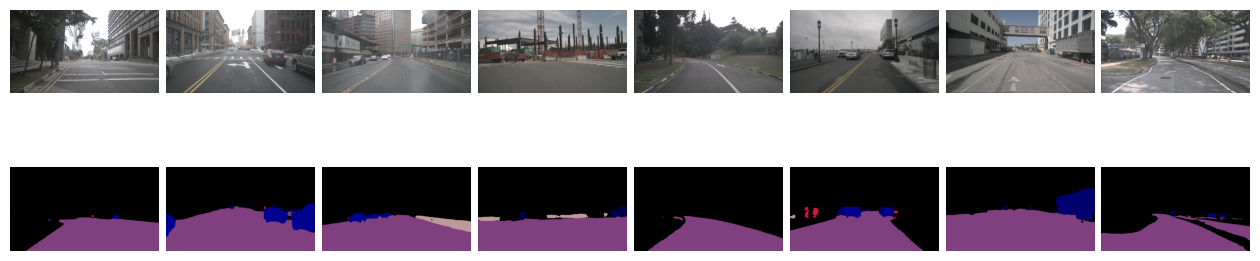

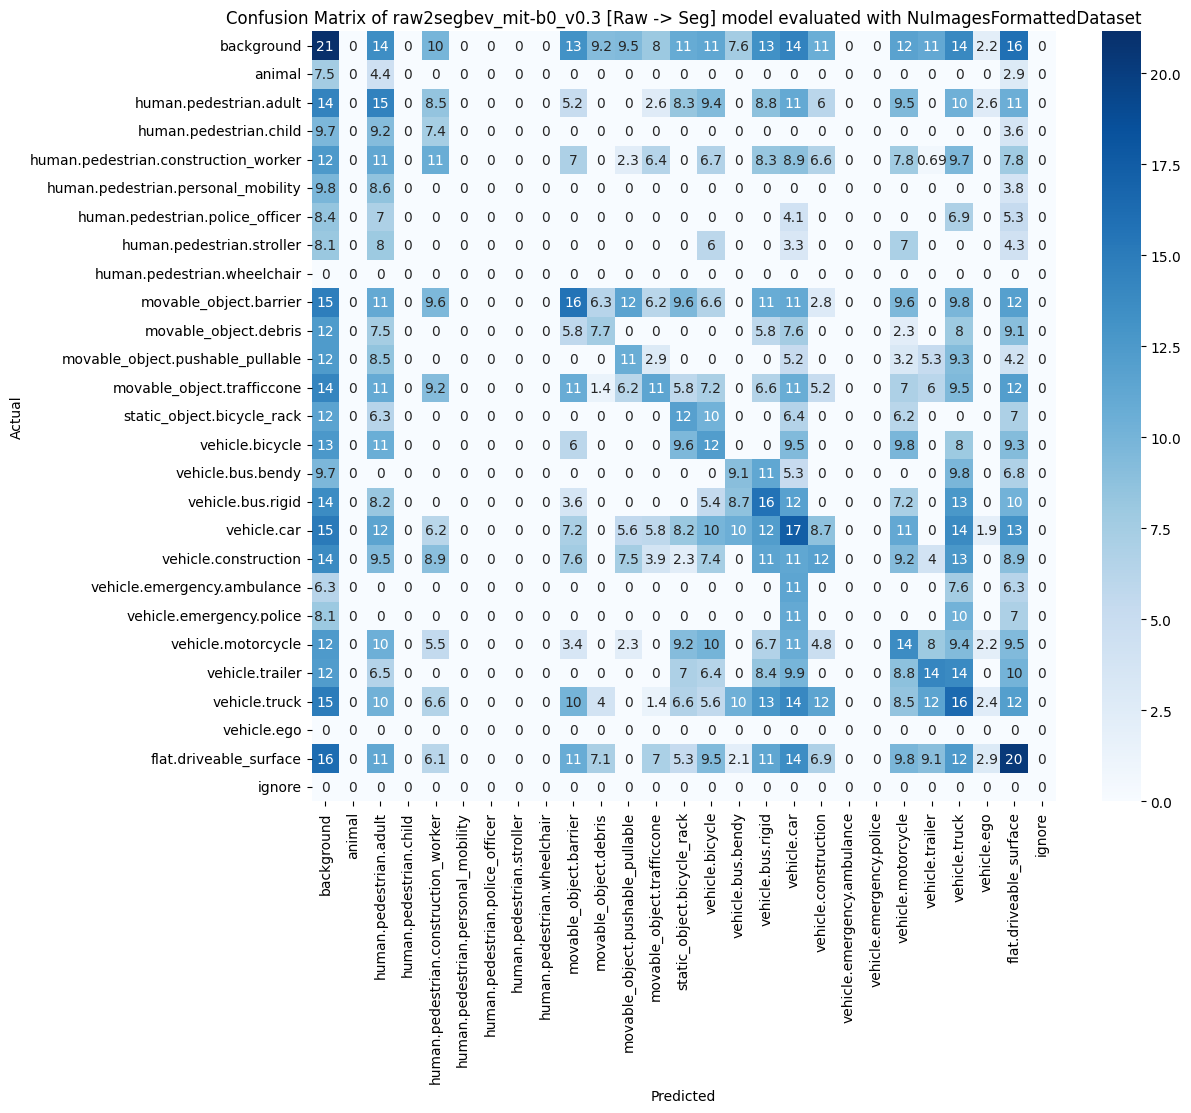

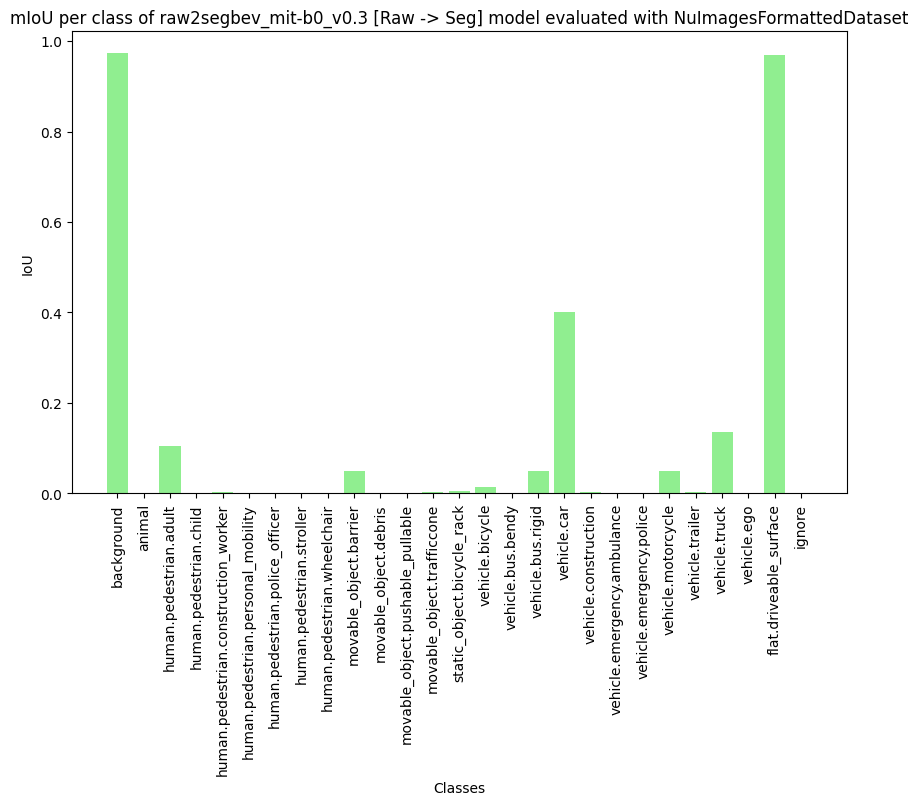

In [6]:
show_qualitative_results(data, "raw2segbev_mit-b0_v0.3", eval_type=2, num_images=8)
show_conf_matrix(data, "raw2segbev_mit-b0_v0.3", eval_type=2)
plot_mean_iou_per_class(data, "raw2segbev_mit-b0_v0.3", eval_type=2, colors='lightgreen')

#### [RAW -> Segmentation -> BEV]

Using device: cuda for inference


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


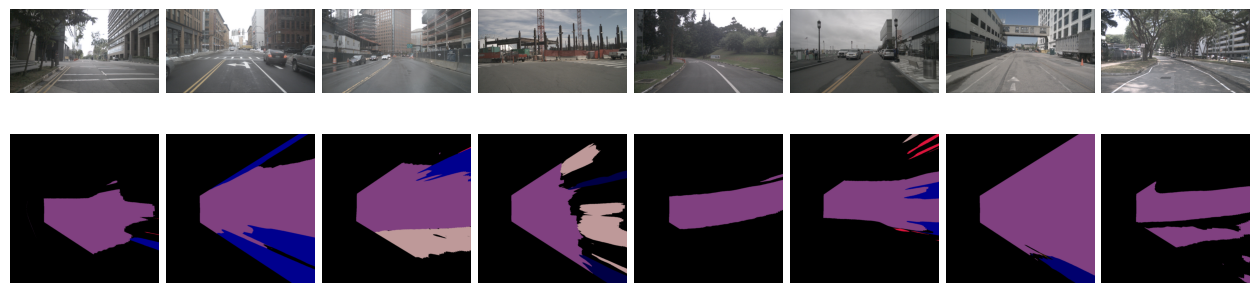

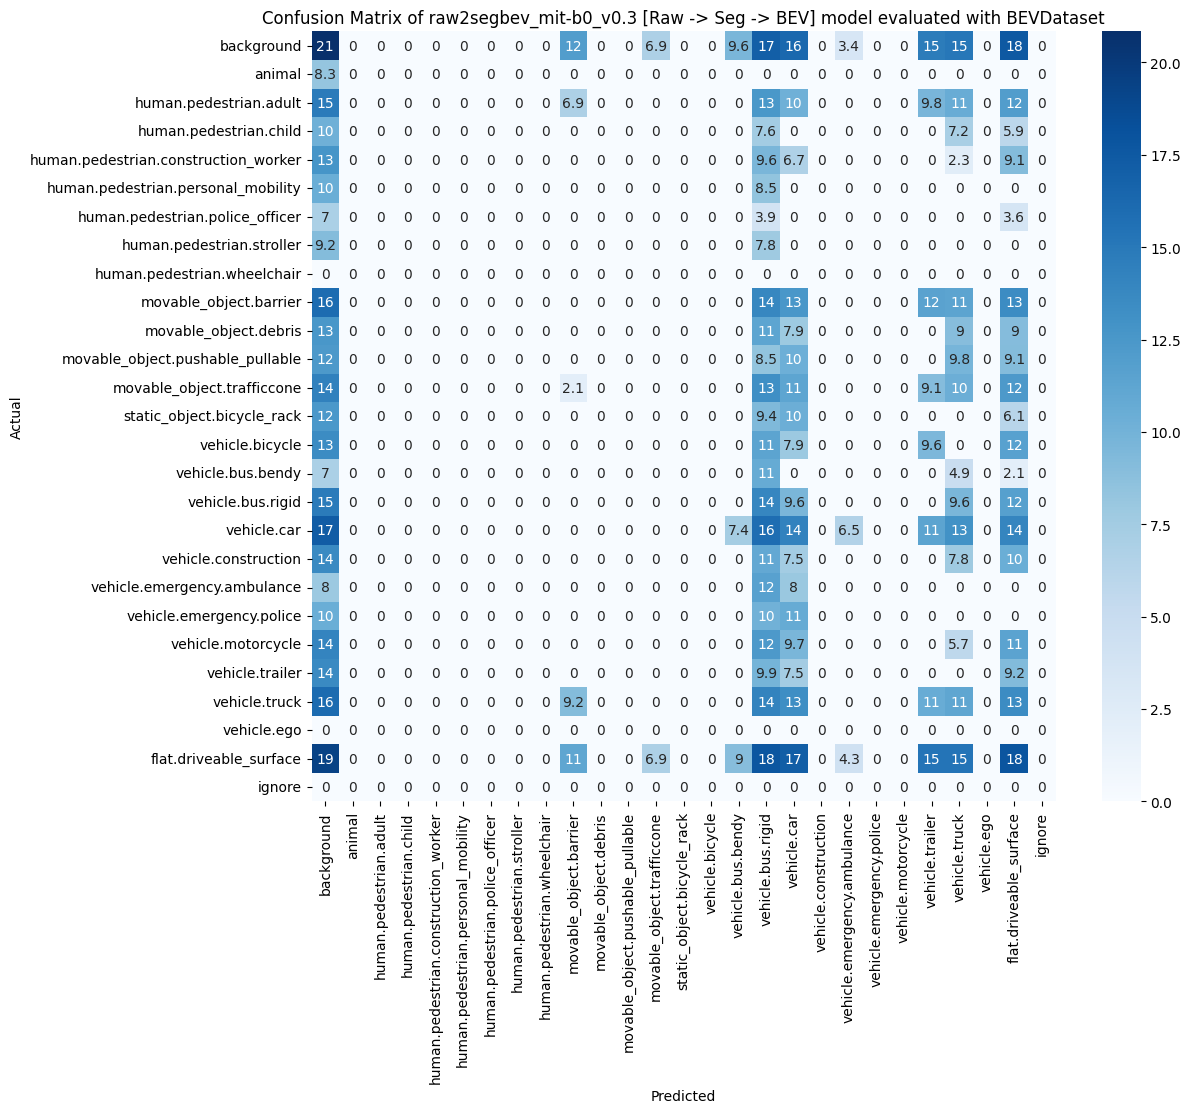

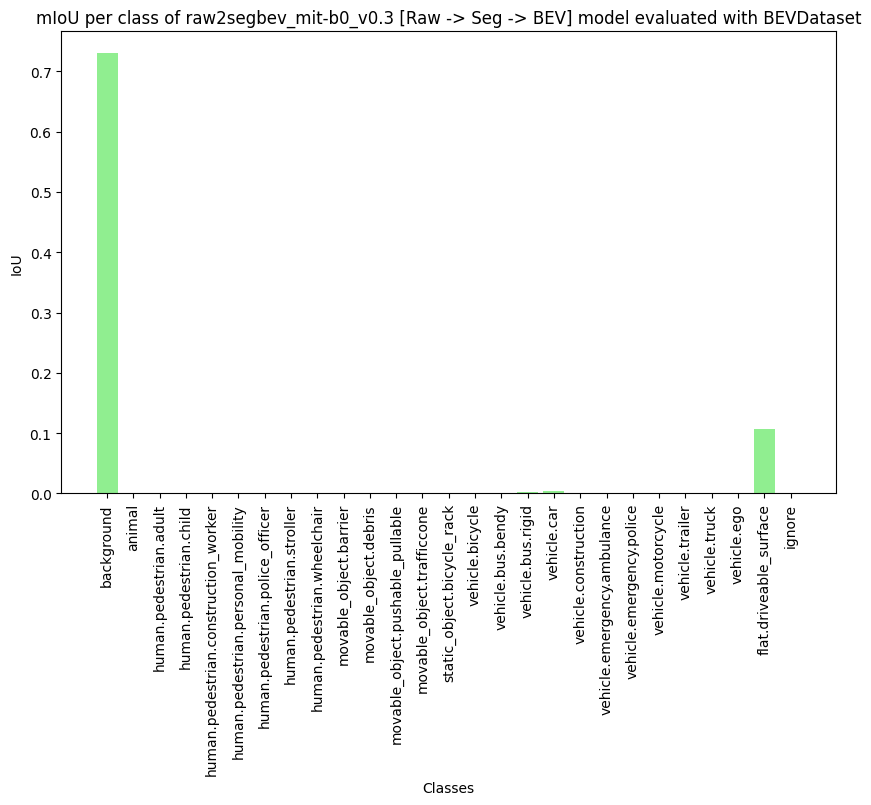

In [7]:
show_qualitative_results(data, "raw2segbev_mit-b0_v0.3", eval_type=1, num_images=8)
show_conf_matrix(data, "raw2segbev_mit-b0_v0.3", eval_type=1)
plot_mean_iou_per_class(data, "raw2segbev_mit-b0_v0.3", eval_type=1, colors='lightgreen')

#### [RAW -> BEV -> Segmentation]

Using device: cuda for inference


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:17<00:00,  2.18s/it]


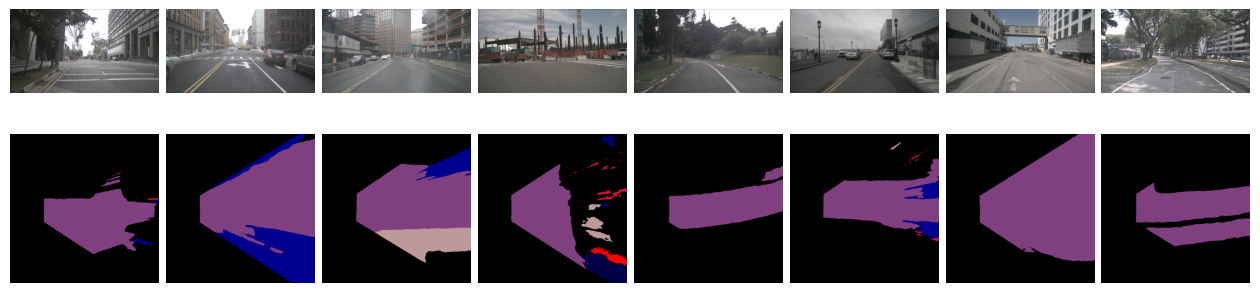

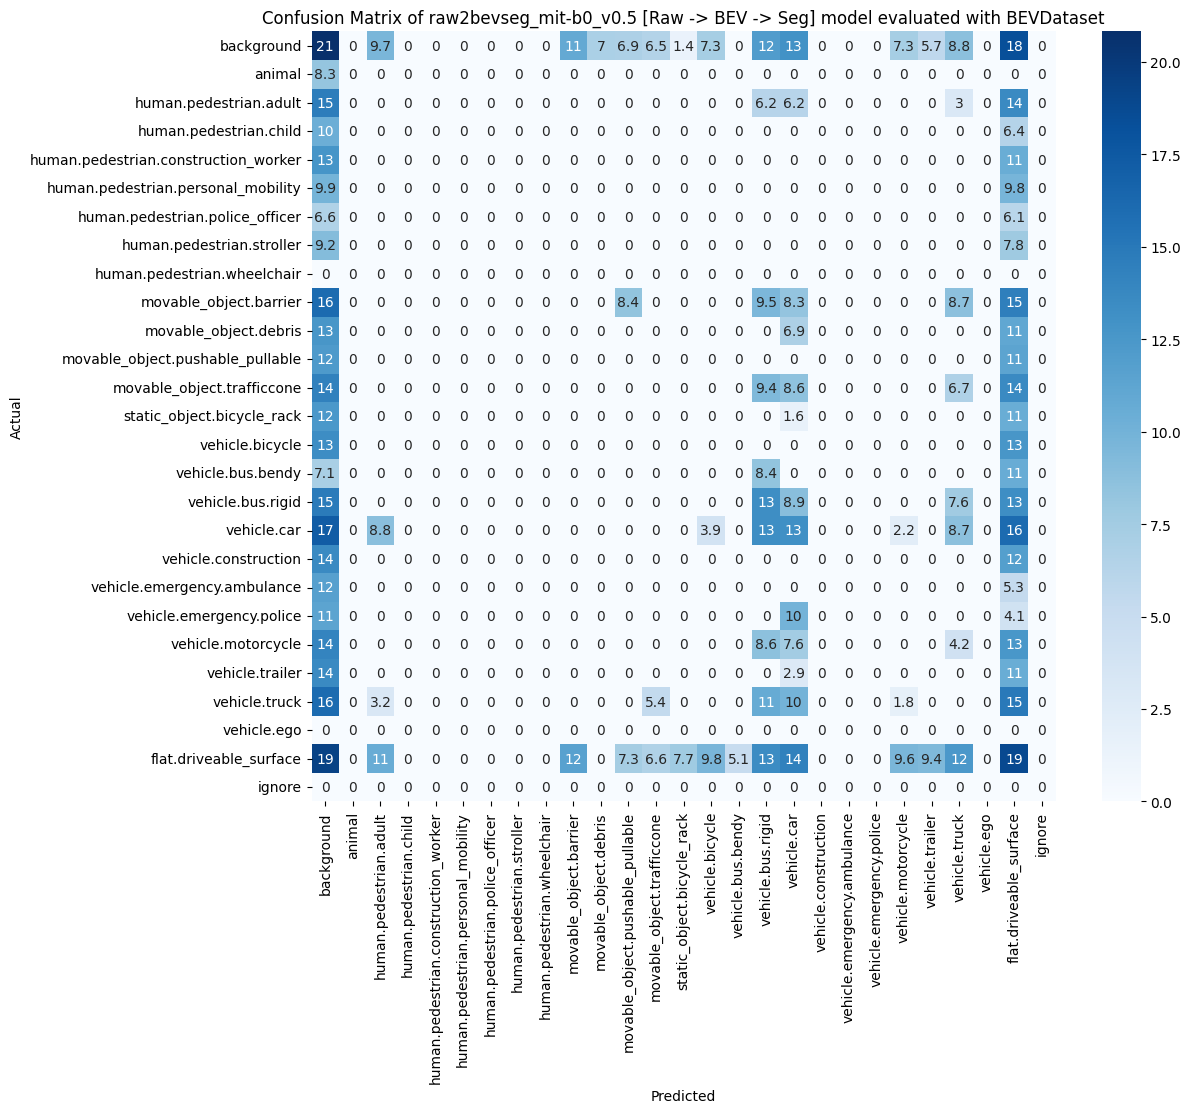

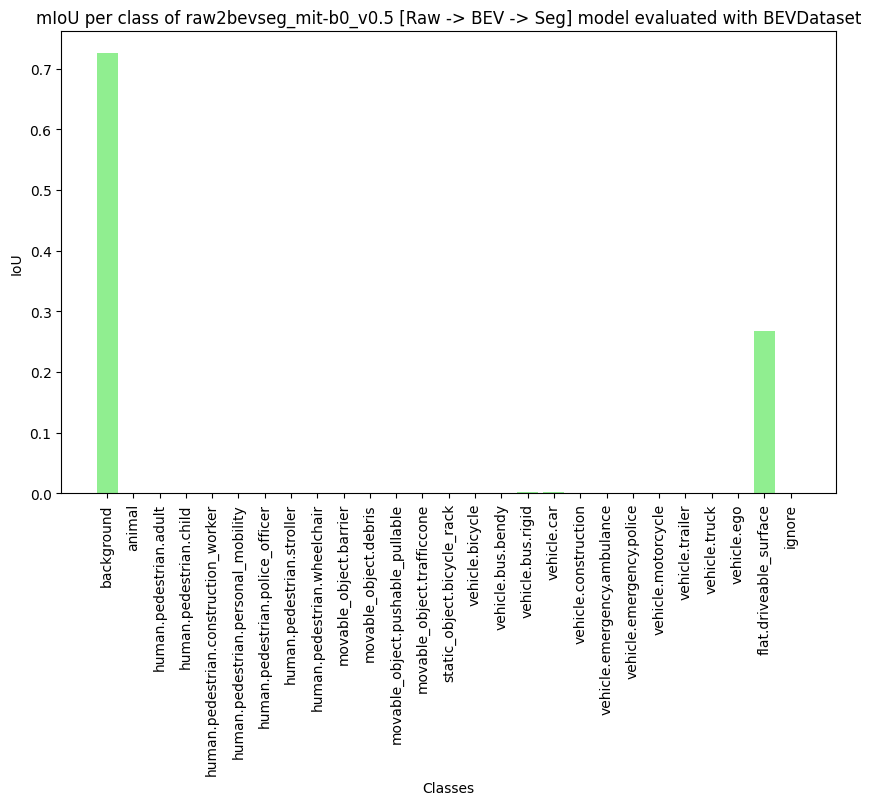

In [8]:
show_qualitative_results(data, "raw2bevseg_mit-b0_v0.5", eval_type=0, num_images=8)
show_conf_matrix(data, "raw2bevseg_mit-b0_v0.5", eval_type=0)
plot_mean_iou_per_class(data, "raw2bevseg_mit-b0_v0.5", eval_type=0, colors='lightgreen')

### **B2 BEV2SEG_2 comparison**

#### Raw segmentation

Using device: cuda for inference


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


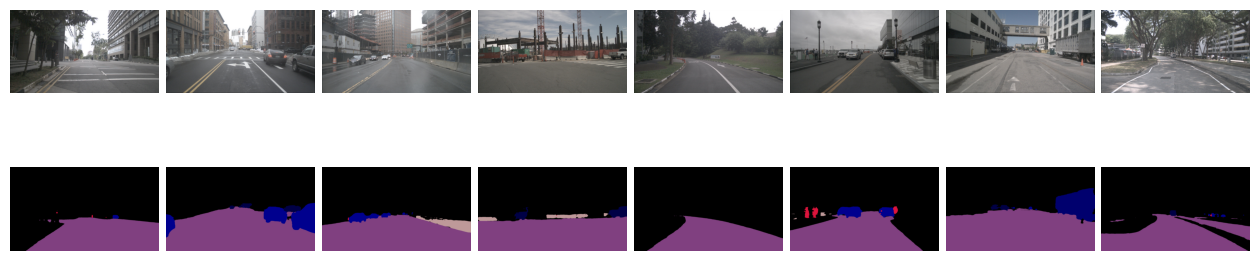

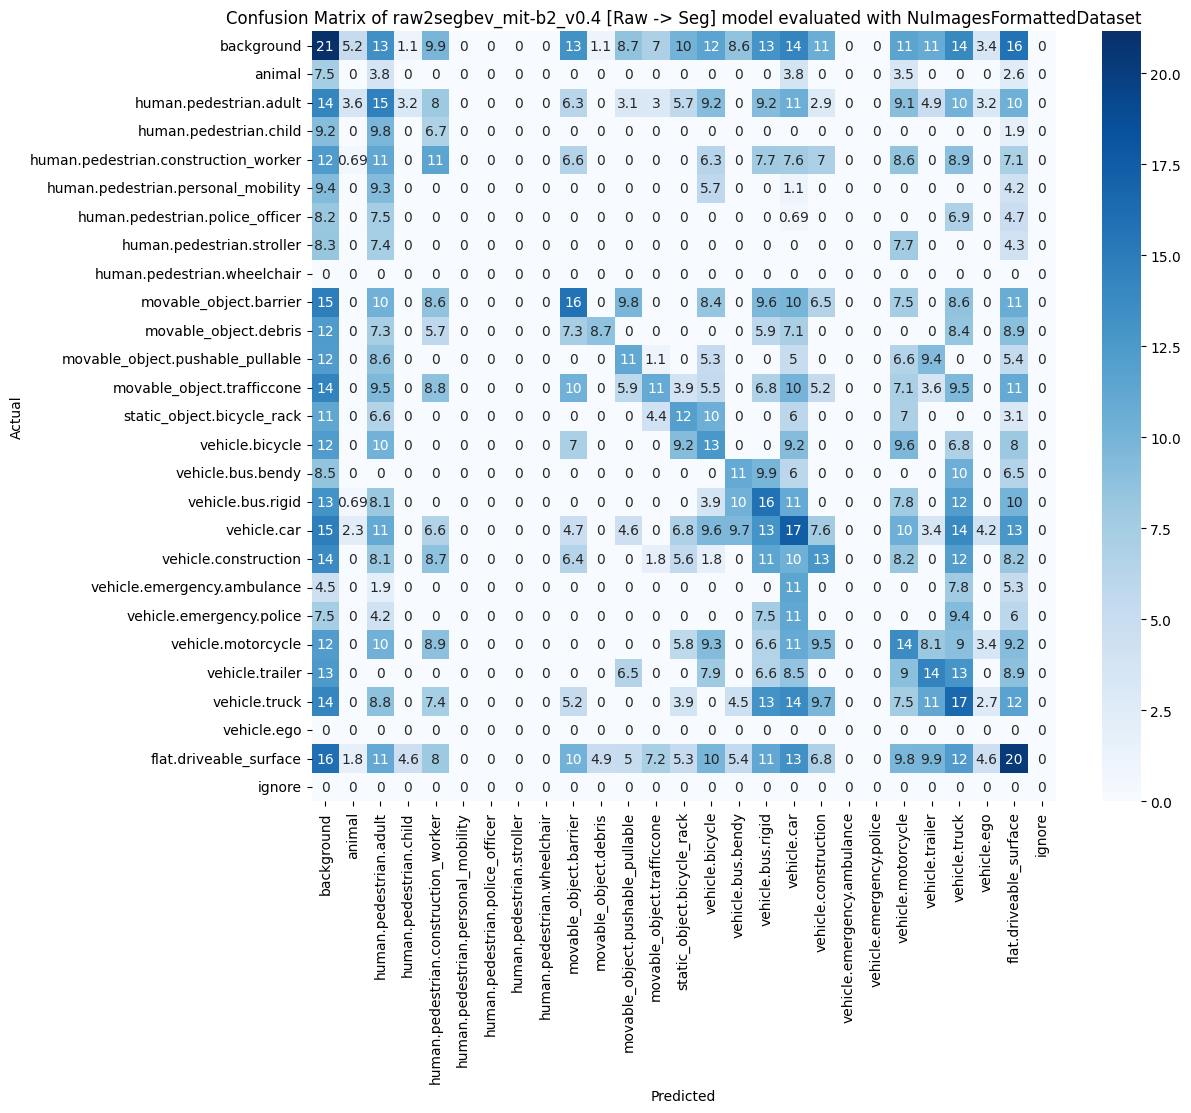

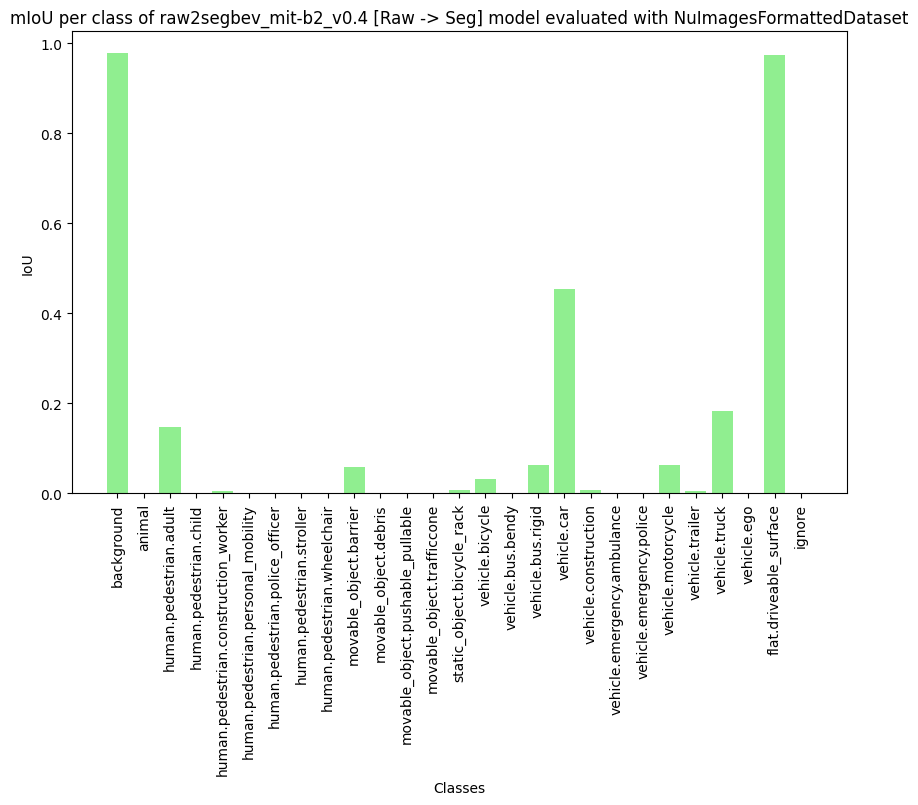

In [9]:
show_qualitative_results(data, "raw2segbev_mit-b2_v0.4", eval_type=2, num_images=8)
show_conf_matrix(data, "raw2segbev_mit-b2_v0.4", eval_type=2)
plot_mean_iou_per_class(data, "raw2segbev_mit-b2_v0.4", eval_type=2, colors='lightgreen')

#### [RAW -> Segmentation -> BEV]

Using device: cuda for inference


100%|██████████| 8/8 [00:17<00:00,  2.23s/it]


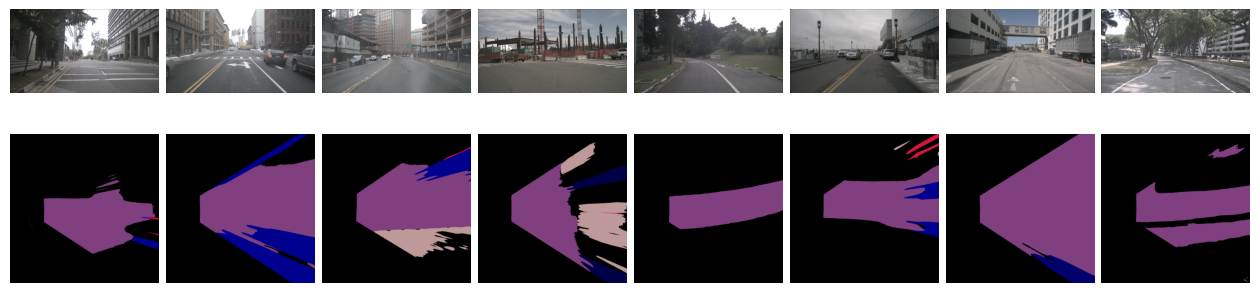

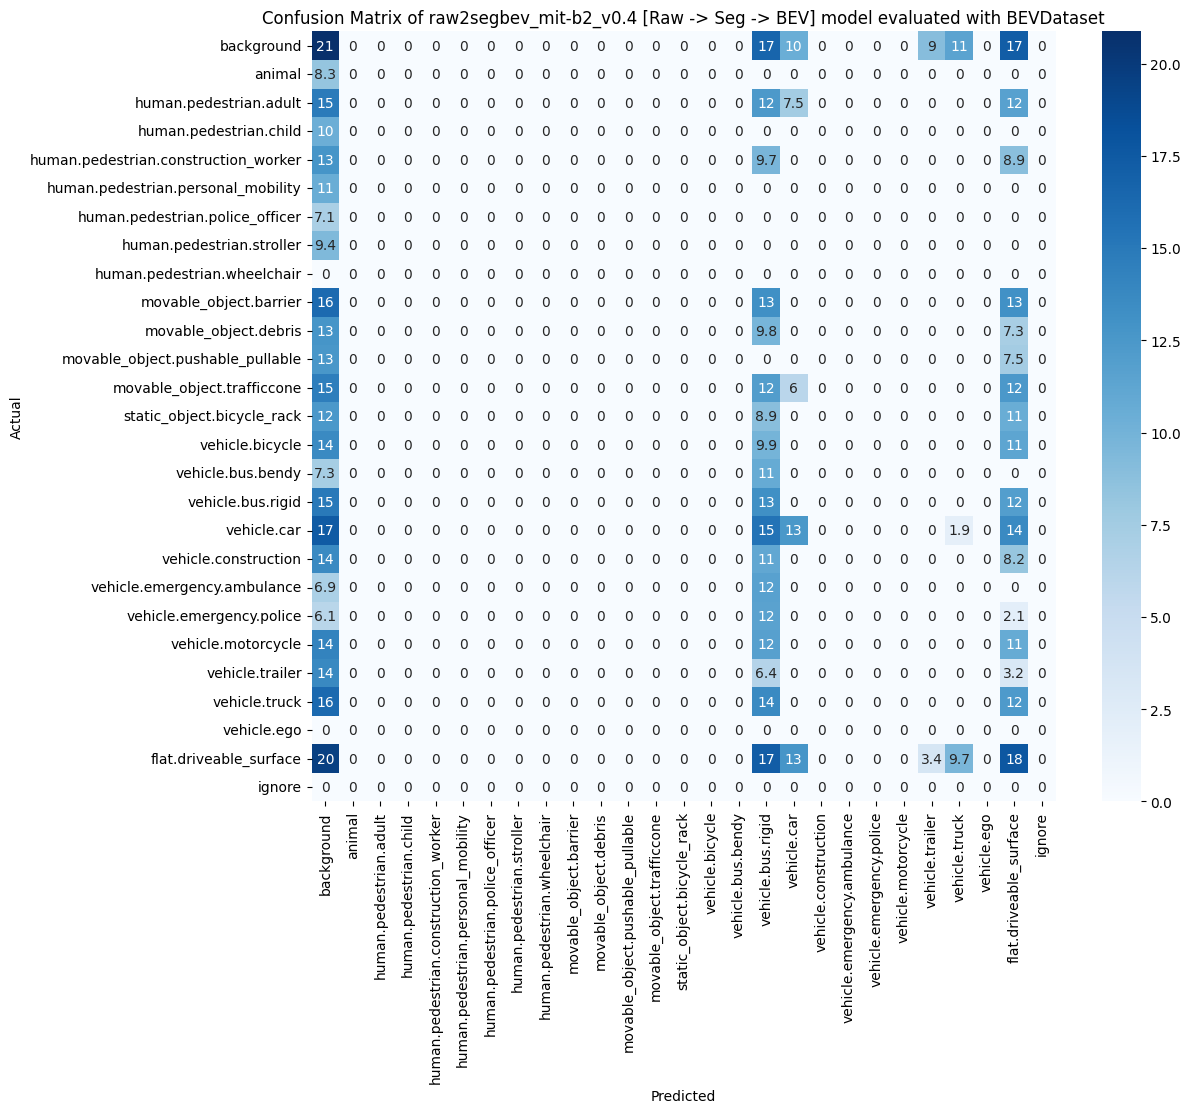

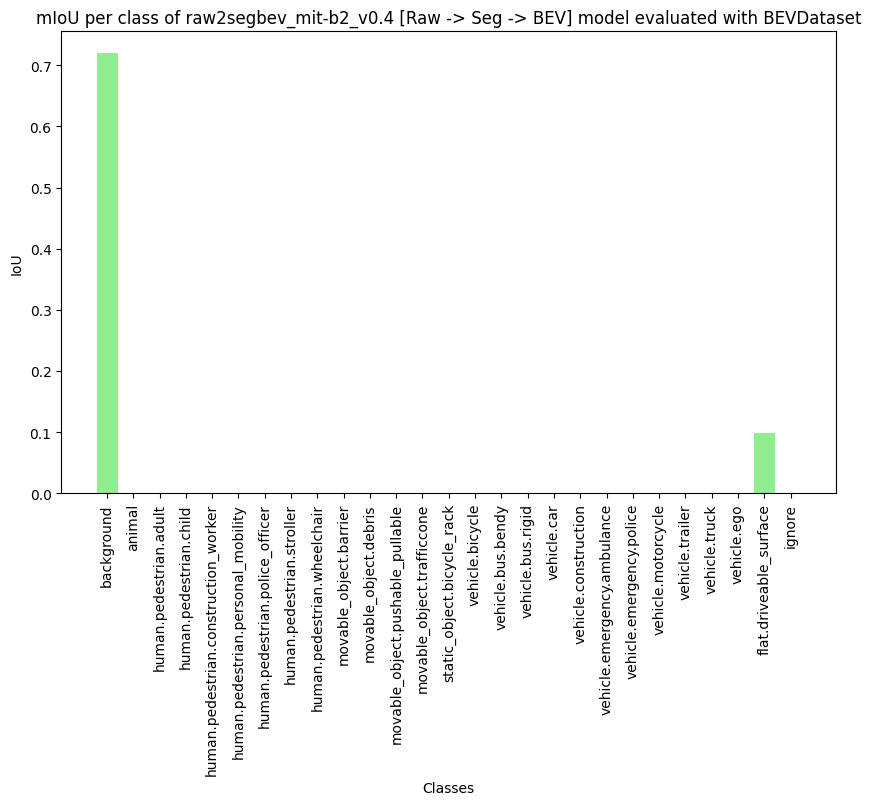

In [10]:
show_qualitative_results(data, "raw2segbev_mit-b2_v0.4", eval_type=1, num_images=8)
show_conf_matrix(data, "raw2segbev_mit-b2_v0.4", eval_type=1)
plot_mean_iou_per_class(data, "raw2segbev_mit-b2_v0.4", eval_type=1, colors='lightgreen')

#### [RAW -> BEV -> Segmentation]

In [11]:
# TODO: =================================

### [RAW -> Segmentation -> BEV] before and after data augmentations

No hay una gran diferencia entre los resultados antes y después de utilizar data augmentations

### RAW Comparison

BEFORE DATA AUG
Using device: cuda for inference


100%|██████████| 8/8 [00:17<00:00,  2.20s/it]


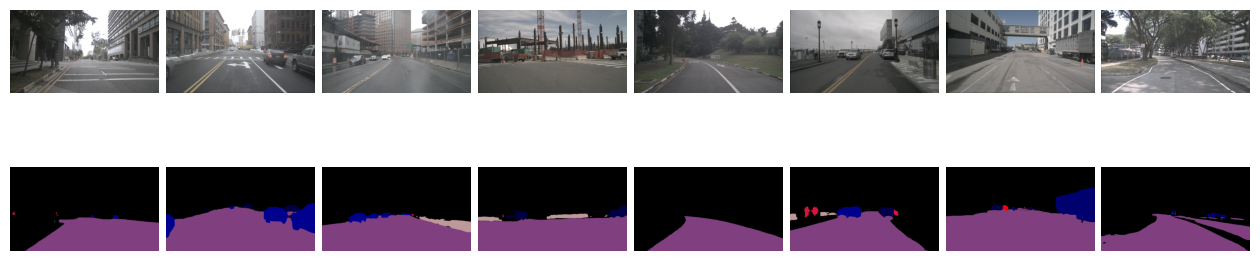


[Raw -> Seg] model evaluated with NuImagesFormattedDataset
raw2segbev_mit-b0_v0.2      background    animal    human.pedestrian.adult    human.pedestrian.child    human.pedestrian.construction_worker    human.pedestrian.personal_mobility    human.pedestrian.police_officer    human.pedestrian.stroller    human.pedestrian.wheelchair    movable_object.barrier    movable_object.debris    movable_object.pushable_pullable    movable_object.trafficcone    static_object.bicycle_rack    vehicle.bicycle    vehicle.bus.bendy    vehicle.bus.rigid    vehicle.car    vehicle.construction    vehicle.emergency.ambulance    vehicle.emergency.police    vehicle.motorcycle    vehicle.trailer    vehicle.truck    vehicle.ego    flat.driveable_surface    ignore
------------------------  ------------  --------  ------------------------  ------------------------  --------------------------------------  ------------------------------------  ---------------------------------  ---------------------------  -------

100%|██████████| 8/8 [00:18<00:00,  2.26s/it]


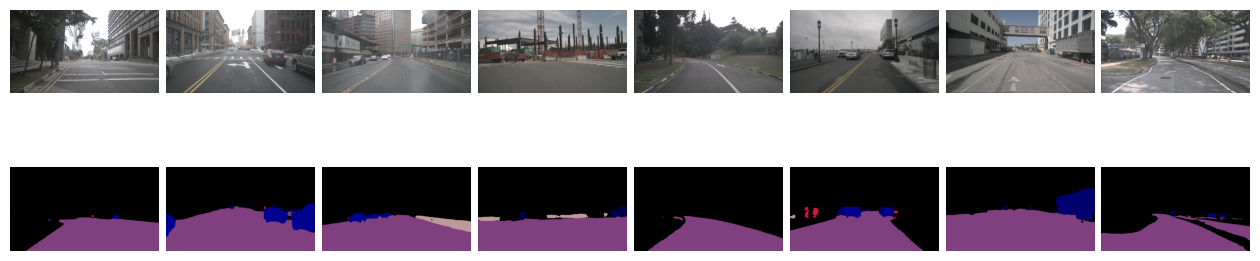


[Raw -> Seg] model evaluated with NuImagesFormattedDataset
raw2segbev_mit-b0_v0.3      background    animal    human.pedestrian.adult    human.pedestrian.child    human.pedestrian.construction_worker    human.pedestrian.personal_mobility    human.pedestrian.police_officer    human.pedestrian.stroller    human.pedestrian.wheelchair    movable_object.barrier    movable_object.debris    movable_object.pushable_pullable    movable_object.trafficcone    static_object.bicycle_rack    vehicle.bicycle    vehicle.bus.bendy    vehicle.bus.rigid    vehicle.car    vehicle.construction    vehicle.emergency.ambulance    vehicle.emergency.police    vehicle.motorcycle    vehicle.trailer    vehicle.truck    vehicle.ego    flat.driveable_surface    ignore
------------------------  ------------  --------  ------------------------  ------------------------  --------------------------------------  ------------------------------------  ---------------------------------  ---------------------------  -------

In [13]:
print(f"BEFORE DATA AUG")
show_qualitative_results(data, "raw2segbev_mit-b0_v0.2", eval_type=2, num_images=8)
show_evals_per_class(data, "raw2segbev_mit-b0_v0.2", eval_type=2)
print()

print(f"AFTER DATA AUG")
show_qualitative_results(data, "raw2segbev_mit-b0_v0.3", eval_type=2, num_images=8)
show_evals_per_class(data, "raw2segbev_mit-b0_v0.3", eval_type=2)

### BEV Comparison

BEFORE DATA AUG
Using device: cuda for inference


100%|██████████| 8/8 [00:17<00:00,  2.16s/it]


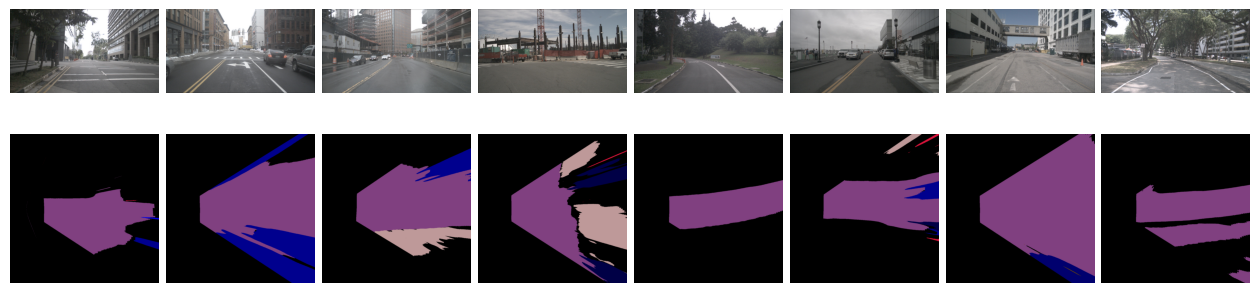


[Raw -> Seg -> BEV] model evaluated with BEVDataset
raw2segbev_mit-b0_v0.2      background    animal    human.pedestrian.adult    human.pedestrian.child    human.pedestrian.construction_worker    human.pedestrian.personal_mobility    human.pedestrian.police_officer    human.pedestrian.stroller    human.pedestrian.wheelchair    movable_object.barrier    movable_object.debris    movable_object.pushable_pullable    movable_object.trafficcone    static_object.bicycle_rack    vehicle.bicycle    vehicle.bus.bendy    vehicle.bus.rigid    vehicle.car    vehicle.construction    vehicle.emergency.ambulance    vehicle.emergency.police    vehicle.motorcycle    vehicle.trailer    vehicle.truck    vehicle.ego    flat.driveable_surface    ignore
------------------------  ------------  --------  ------------------------  ------------------------  --------------------------------------  ------------------------------------  ---------------------------------  ---------------------------  --------------

100%|██████████| 8/8 [00:17<00:00,  2.17s/it]


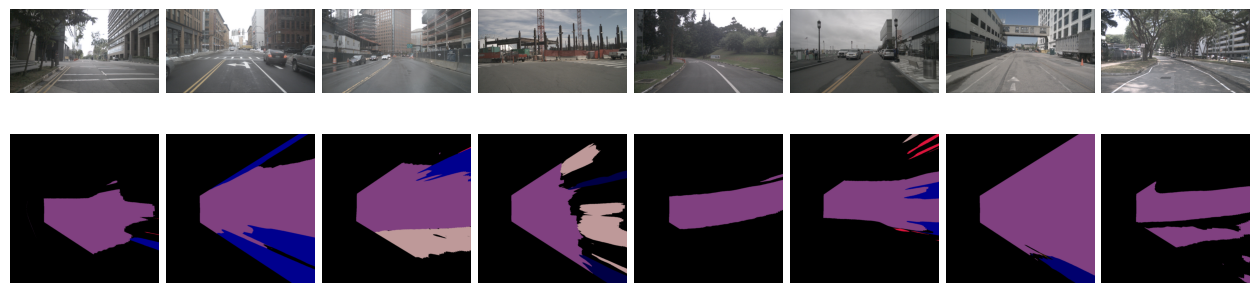


[Raw -> Seg -> BEV] model evaluated with BEVDataset
raw2segbev_mit-b0_v0.3      background    animal    human.pedestrian.adult    human.pedestrian.child    human.pedestrian.construction_worker    human.pedestrian.personal_mobility    human.pedestrian.police_officer    human.pedestrian.stroller    human.pedestrian.wheelchair    movable_object.barrier    movable_object.debris    movable_object.pushable_pullable    movable_object.trafficcone    static_object.bicycle_rack    vehicle.bicycle    vehicle.bus.bendy    vehicle.bus.rigid    vehicle.car    vehicle.construction    vehicle.emergency.ambulance    vehicle.emergency.police    vehicle.motorcycle    vehicle.trailer    vehicle.truck    vehicle.ego    flat.driveable_surface    ignore
------------------------  ------------  --------  ------------------------  ------------------------  --------------------------------------  ------------------------------------  ---------------------------------  ---------------------------  --------------

In [5]:
print(f"BEFORE DATA AUG")
show_qualitative_results(data, "raw2segbev_mit-b0_v0.2", eval_type=1, num_images=8)
show_evals_per_class(data, "raw2segbev_mit-b0_v0.2", eval_type=1)
print()

print(f"AFTER DATA AUG")
show_qualitative_results(data, "raw2segbev_mit-b0_v0.3", eval_type=1, num_images=8)
show_evals_per_class(data, "raw2segbev_mit-b0_v0.3", eval_type=1)

### [RAW -> BEV -> Segmentation] before and after data augmentations 

In [ ]:
print(f"BEFORE DATA AUG")
show_qualitative_results(data, "raw2bevseg_mit-b0_v0.4", eval_type=0, num_images=8)
show_evals_per_class(data, "raw2bevseg_mit-b0_v0.4", eval_type=0)
print()

print(f"AFTER DATA AUG")
show_qualitative_results(data, "raw2bevseg_mit-b0_v0.5", eval_type=0, num_images=8)
show_evals_per_class(data, "raw2bevseg_mit-b0_v0.5", eval_type=0)